In [3]:
# --- Notebook test block for ConditionMixers ---
import sys, os
sys.path.append(r"C:\Users\Hagai.LAPTOP-QAG9263N\Desktop\Thesis\repositories\ImagiNav")
import torch
from modules.condition_mixer import ConditionMixer, ConcatMixer, WeightedMixer


In [9]:

device = "cuda" if torch.cuda.is_available() else "cpu"

# Synthetic condition inputs
B, pov_dim, graph_dim = 1, 512, 384
H, W = 64, 64
target_size = (H, W)
out_channels = 4

# Simulate embeddings
pov_vec = torch.randn(B, pov_dim, device=device)
graph_vec = torch.randn(B, graph_dim, device=device)

pov_map = torch.randn(B, pov_dim, 8, 8, device=device)
graph_map = torch.randn(B, graph_dim, 4, 4, device=device)

print("=== ConcatMixer (vector inputs) ===")
concat_vec = ConcatMixer(out_channels, target_size, pov_channels=pov_dim, graph_channels=graph_dim).to(device)
out_vec = concat_vec([pov_vec, graph_vec])
print(out_vec.shape, torch.mean(out_vec).item(), torch.std(out_vec).item())

print("=== ConcatMixer (map inputs) ===")
concat_map = ConcatMixer(out_channels, target_size, pov_channels=pov_dim, graph_channels=graph_dim).to(device)
out_map = concat_map([pov_map, graph_map])
print(out_map.shape, torch.mean(out_map).item(), torch.std(out_map).item())

print("=== WeightedMixer (vector inputs) ===")
weighted_vec = WeightedMixer(out_channels, target_size, pov_channels=pov_dim, graph_channels=graph_dim).to(device)
weights = torch.tensor([0.7, 0.3], device=device)
out_weighted_vec = weighted_vec([pov_vec, graph_vec], weights)
print(out_weighted_vec.shape, torch.mean(out_weighted_vec).item(), torch.std(out_weighted_vec).item())

print("=== WeightedMixer (map inputs) ===")
weighted_map = WeightedMixer(out_channels, target_size, pov_channels=pov_dim, graph_channels=graph_dim).to(device)
out_weighted_map = weighted_map([pov_map, graph_map], weights)
print(out_weighted_map.shape, torch.mean(out_weighted_map).item(), torch.std(out_weighted_map).item())

# Sanity check: confirm output differences for distinct weights
diff = torch.mean(torch.abs(out_weighted_vec - weighted_vec([pov_vec, graph_vec], torch.tensor([0.3, 0.7], device=device))))
print("Mean absolute diff when flipping weights:", diff.item())


=== ConcatMixer (vector inputs) ===
torch.Size([1, 4, 64, 64]) 0.003981695510447025 0.5779626369476318
=== ConcatMixer (map inputs) ===
torch.Size([1, 4, 64, 64]) -0.06345978379249573 0.48621276021003723
=== WeightedMixer (vector inputs) ===
torch.Size([1, 4, 64, 64]) 0.0018093297258019447 0.4267486333847046
=== WeightedMixer (map inputs) ===
torch.Size([1, 4, 64, 64]) 0.018864408135414124 0.3086324632167816
Mean absolute diff when flipping weights: 0.26110997796058655


In [10]:
print("=== ConcatMixer (POV=None) ===")
concat_missing = ConcatMixer(out_channels, target_size, pov_channels=pov_dim, graph_channels=graph_dim).to(device)
out_concat_missing = concat_missing([None, graph_vec])
print(out_concat_missing.shape, torch.mean(out_concat_missing).item(), torch.std(out_concat_missing).item())

print("=== WeightedMixer (POV=None) ===")
weighted_missing = WeightedMixer(out_channels, target_size, pov_channels=pov_dim, graph_channels=graph_dim).to(device)
out_weighted_missing = weighted_missing([None, graph_vec])
print(out_weighted_missing.shape, torch.mean(out_weighted_missing).item(), torch.std(out_weighted_missing).item())

print("=== ConditionMixer base (POV=None) ===")
try:
    base_missing = ConditionMixer(out_channels, target_size, pov_channels=pov_dim, graph_channels=graph_dim).to(device)
    out_base_missing = base_missing([None, graph_vec])
except NotImplementedError:
    print("ConditionMixer.forward() not implemented — expected.")


=== ConcatMixer (POV=None) ===
torch.Size([1, 4, 64, 64]) 0.0017212389502674341 0.42519041895866394
=== WeightedMixer (POV=None) ===
torch.Size([1, 4, 64, 64]) -0.0001841332414187491 0.30228501558303833
=== ConditionMixer base (POV=None) ===
ConditionMixer.forward() not implemented — expected.


In [11]:
print("=== ConcatMixer (graph=None) ===")
concat_no_graph = ConcatMixer(out_channels, target_size, pov_channels=pov_dim, graph_channels=graph_dim).to(device)
out_concat_no_graph = concat_no_graph([pov_vec, None])
print(out_concat_no_graph.shape, torch.mean(out_concat_no_graph).item(), torch.std(out_concat_no_graph).item())

print("=== WeightedMixer (graph=None) ===")
weighted_no_graph = WeightedMixer(out_channels, target_size, pov_channels=pov_dim, graph_channels=graph_dim).to(device)
out_weighted_no_graph = weighted_no_graph([pov_vec, None])
print(out_weighted_no_graph.shape, torch.mean(out_weighted_no_graph).item(), torch.std(out_weighted_no_graph).item())


=== ConcatMixer (graph=None) ===
torch.Size([1, 4, 64, 64]) 0.002260455396026373 0.3914865255355835
=== WeightedMixer (graph=None) ===
torch.Size([1, 4, 64, 64]) 0.0013712919317185879 0.27598199248313904


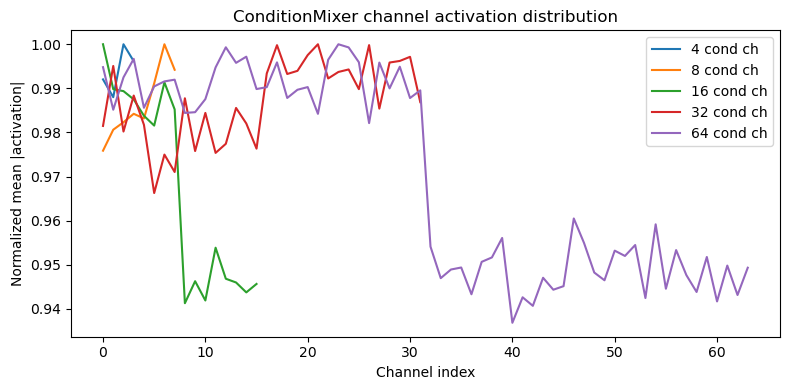

In [14]:
import torch
import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"

pov_dim, graph_dim = 128, 256
target_size = (64, 64)

def channel_energy(mixer):
    pov_vec = torch.randn(4, pov_dim, device=device)
    graph_vec = torch.randn(4, graph_dim, device=device)
    cond = mixer([pov_vec, graph_vec])
    return cond.abs().mean(dim=(0,2,3)).detach().cpu().numpy()

channel_counts = [4, 8, 16, 32, 64]
energies = []
for c in channel_counts:
    m = ConcatMixer(out_channels=c, target_size=target_size, 
                    pov_channels=pov_dim, graph_channels=graph_dim).to(device)
    e = channel_energy(m)
    energies.append(e)

plt.figure(figsize=(8,4))
for c, e in zip(channel_counts, energies):
    plt.plot(range(len(e)), e / e.max(), label=f"{c} cond ch")
plt.xlabel("Channel index")
plt.ylabel("Normalized mean |activation|")
plt.title("ConditionMixer channel activation distribution")
plt.legend()
plt.tight_layout()
plt.show()


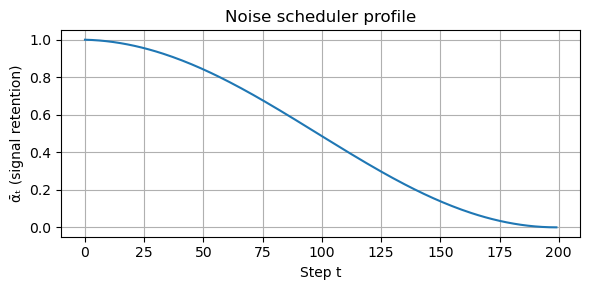

In [15]:
import torch
import matplotlib.pyplot as plt
from modules.scheduler import CosineScheduler
scheduler = CosineScheduler(num_steps=200)  # your loaded cosine scheduler
steps = scheduler.num_steps
alphas_bar = scheduler.alpha_bars[:steps]

plt.figure(figsize=(6,3))
plt.plot(range(steps), alphas_bar.cpu().numpy())
plt.xlabel("Step t")
plt.ylabel("ᾱₜ (signal retention)")
plt.title("Noise scheduler profile")
plt.grid(True)
plt.tight_layout()
plt.show()
